## Pronóstico de series de tiempo de precipitación con autoencoder y DMD

In [1]:
import pandas as pd
import numpy as np

# Leer los datos desde el archivo CSV
# Supongamos que el archivo CSV tiene N filas (observaciones) y P columnas (estaciones)
data_df = pd.read_csv('../data/precipitation_test.csv')

# Convertir el DataFrame a un array de NumPy
data = data_df.values

# Verificar la forma de los datos
print(data.shape)  # Esto imprimirá (N, P), donde N es el número de observaciones y P es el número de estaciones.
# Guardar los datos en formato .npy
np.save('../data/precipitation_data.npy', data)

(1826, 30)


In [2]:
import xarray as xr
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pydmd import DMD

# Parámetros del espacio latente
latent_dim = 100 # Ajustar la dimensión del espacio latente

2025-10-04 22:31:36.752164: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-04 22:31:36.783892: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-04 22:31:36.783915: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-04 22:31:36.783932: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-04 22:31:36.790548: I tensorflow/core/platform/cpu_feature_g

In [3]:
# Ruta del archivo (ya debe estar en la carpeta montada)
archivo = "../data/ERA5_daily_precipitation_1950_2022.nc"

# Abrir dataset
ds = xr.open_dataset(archivo)
ds

<xarray.Dataset> Size: 678MB
Dimensions:    (time: 26663, latitude: 155, longitude: 41)
Coordinates:
  * longitude  (longitude) float32 164B -76.0 -75.75 -75.5 ... -66.25 -66.0
  * latitude   (latitude) float32 620B -17.5 -17.75 -18.0 ... -55.5 -55.75 -56.0
  * time       (time) datetime64[ns] 213kB 1950-01-01T12:00:00 ... 2022-12-31...
Data variables:
    tp         (time, latitude, longitude) float32 678MB ...

In [4]:

ds = ds.sel(time=slice("2000-01-01", "2022-12-31")) # Filtra desde 2000 a 2022
ds = ds.sel(latitude=slice(-30, -40)) # Filtra zona central
ds

<xarray.Dataset> Size: 57MB
Dimensions:    (time: 8401, latitude: 41, longitude: 41)
Coordinates:
  * longitude  (longitude) float32 164B -76.0 -75.75 -75.5 ... -66.25 -66.0
  * latitude   (latitude) float32 164B -30.0 -30.25 -30.5 ... -39.5 -39.75 -40.0
  * time       (time) datetime64[ns] 67kB 2000-01-01T12:00:00 ... 2022-12-31T...
Data variables:
    tp         (time, latitude, longitude) float32 56MB ...

In [5]:
import numpy as np
import xarray as xr
import tensorflow as tf
from numpy.lib.stride_tricks import sliding_window_view

# =========================
# 2) Ordena coords: lon O→E, lat S→N
# =========================
if float(ds.longitude[0]) > float(ds.longitude[-1]):
    ds = ds.sortby("longitude")
# ERA5 suele traer lat N→S; queremos S→N (ascendente)
if float(ds.latitude[0]) > float(ds.latitude[-1]):
    ds = ds.sortby("latitude")

In [6]:
# =========================
# 3) Extrae tensor base (T, H, W, C)
# =========================
tp = ds["tp"]  # mm por paso temporal
# Asegura dtype
tp = tp.astype("float32")

# Manejo de NaNs: relleno + canal máscara (opcional)
use_mask_channel = False
if tp.isnull().any():
    use_mask_channel = True
    mask = xr.where(tp.notnull(), 1.0, 0.0).astype("float32")
    tp = tp.fillna(0.0)

# A (T,H,W)
X = tp.transpose("time", "latitude", "longitude").values  # -> (T,H,W)
T_total, H, W = X.shape

# Apila canales
channels = [X[..., None]]  # C=1
if use_mask_channel:
    M = mask.transpose("time", "latitude", "longitude").values.astype("float32")
    channels.append(M[..., None])  # C+=1
X_full = np.concatenate(channels, axis=-1).astype("float32")  # (T,H,W,C)
C = X_full.shape[-1]

print("Forma maestro:", X_full.shape)  # esperado: (8401, 41, 41, C)

Forma maestro: (8401, 41, 41, 1)


In [7]:
# =========================
# 4) Splits temporales (ajusta fechas a tu rango real)
# =========================
# Usa las fechas del dataset para que no falle si no tienes todo 2000–2022
t0 = np.datetime_as_string(ds.time.values[0], unit="D")
t1 = np.datetime_as_string(ds.time.values[-1], unit="D")
print("Rango temporal:", t0, "→", t1)

Rango temporal: 2000-01-01 → 2022-12-31


In [8]:
# Ejemplo: Train hasta 2017-12-31, Val 2018-01-01..2019-12-31, Test 2020-01-01..fin
ds_train = ds.sel(time=slice("2000-01-01", "2017-12-31"))
ds_val   = ds.sel(time=slice("2018-01-01", "2019-12-31"))
ds_test  = ds.sel(time=slice("2020-01-01", None))

def to_array(dsi):
    arr = dsi["tp"].transpose("time", "latitude", "longitude").astype("float32")
    if use_mask_channel:
        m = xr.where(dsi["tp"].notnull(), 1.0, 0.0).transpose("time","latitude","longitude").astype("float32")
        arr = xr.concat([arr, m], dim="channel")  # (time, lat, lon, channel) pero falta expand
        arr = arr.transpose("time","latitude","longitude","channel")
        return arr.values
    else:
        return arr.values[..., None]

Xtr = to_array(ds_train)
Xva = to_array(ds_val)
Xte = to_array(ds_test)

print("Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape)

Train: (6575, 41, 41, 1) Val: (730, 41, 41, 1) Test: (1096, 41, 41, 1)


In [9]:
# =========================
# 5) Normalización (solo con TRAIN)
#    z-score por canal; para precip muy sesgada podrías hacer log1p antes
# =========================
# Si quieres log1p solo en canal 0 (tp), descomenta:
# Xtr[...,0] = np.log1p(Xtr[...,0])
# Xva[...,0] = np.log1p(Xva[...,0])
# Xte[...,0] = np.log1p(Xte[...,0])

# Stats por canal usando train (media/σ sobre (time, lat, lon))
mu = Xtr.reshape(-1, C).mean(axis=0)
sd = Xtr.reshape(-1, C).std(axis=0) + 1e-8

def normalize(x, mu, sd):
    return (x - mu.reshape(1,1,1,C)) / sd.reshape(1,1,1,C)

Xtr = normalize(Xtr, mu, sd).astype("float32")
Xva = normalize(Xva, mu, sd).astype("float32")
Xte = normalize(Xte, mu, sd).astype("float32")

# =========================
# 6) Ventaneo temporal (N, T, H, W, C)
# =========================
T_window = 32   # longitud de ventana
stride   = 4    # salto entre ventanas


def make_windows(X4d, T=32, S=4):
    """
    X4d: (T_total, H, W, C)  ->  (N, T, H, W, C)
    Ventaneo solo en tiempo, con stride S.
    """
    tlen = X4d.shape[0]
    if tlen < T:
        return np.empty((0, T) + X4d.shape[1:], dtype=X4d.dtype)
    starts = np.arange(0, tlen - T + 1, S, dtype=int)
    out = np.empty((len(starts), T) + X4d.shape[1:], dtype=X4d.dtype)
    for j, i in enumerate(starts):
        out[j] = X4d[i:i+T]   # (T, H, W, C)
    return out


Xtr_w = make_windows(Xtr, T_window, stride)
Xva_w = make_windows(Xva, T_window, stride)
Xte_w = make_windows(Xte, T_window, stride)

print("Windows → Train:", Xtr_w.shape, "Val:", Xva_w.shape, "Test:", Xte_w.shape)
# Ejemplo esperado con T_total~8401: (≈2093, 32, 41, 41, C)

Windows → Train: (1636, 32, 41, 41, 1) Val: (175, 32, 41, 41, 1) Test: (267, 32, 41, 41, 1)


In [10]:
# =========================
# 7) tf.data Datasets
# =========================
batch_size = 8
AUTOTUNE = tf.data.AUTOTUNE

def to_ds(X):
    ds = tf.data.Dataset.from_tensor_slices((X, X))  # AE: input = target
    ds = ds.shuffle(min(len(X), 4096), reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = to_ds(Xtr_w)
val_ds   = tf.data.Dataset.from_tensor_slices((Xva_w, Xva_w)).batch(batch_size).prefetch(AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((Xte_w, Xte_w)).batch(batch_size)

2025-10-04 22:31:42.394893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-04 22:31:42.402998: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-04 22:31:42.403108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-04 22:31:42.406573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-04 22:31:42.406624: I tensorflow/compile

In [11]:
# === antes de construir el modelo ===
H, W = 41, 41          # tus dims actuales
t_factor = 2*2*2       # por si cambias strides en tiempo (aquí 8)
sp_factor = 2*2*2*2    # factor espacial total (aquí 16)

def pad_to_multiple(n, k):
    need = (-n) % k               # cuánto falta para múltiplo de k
    return need // 2, need - need // 2  # reparto (arriba/abajo)

pad_h = pad_to_multiple(H, sp_factor)   # (3,4) para 41→48
pad_w = pad_to_multiple(W, sp_factor)   # (3,4) para 41→48
print("padding H,W:", pad_h, pad_w)

padding H,W: (3, 4) (3, 4)


In [12]:
# =========================
# 8) Autoencoder 3D básico (channels_last)
#     Input: (T,H,W,C)
# =========================
from tensorflow.keras import layers, Model

input_shape = (T_window, H, W, C)
inp = layers.Input(shape=input_shape)

# PAD al inicio → (T, 48, 48, C)
x = layers.ZeroPadding3D(padding=((0,0), pad_h, pad_w))(inp)

# Encoder
x = layers.Conv3D(16, (3,3,3), strides=(1,2,2), padding="same", activation="relu")(x)
x = layers.Conv3D(32, (3,3,3), strides=(2,2,2), padding="same", activation="relu")(x)
x = layers.Conv3D(64, (3,3,3), strides=(2,2,2), padding="same", activation="relu")(x)
z = layers.Conv3D(128,(3,3,3), strides=(2,2,2), padding="same", activation="relu")(x)

# Decoder (espejo)
x = layers.Conv3DTranspose(64, (3,3,3), strides=(2,2,2), padding="same", activation="relu")(z)
x = layers.Conv3DTranspose(32, (3,3,3), strides=(2,2,2), padding="same", activation="relu")(x)
x = layers.Conv3DTranspose(16, (3,3,3), strides=(2,2,2), padding="same", activation="relu")(x)
x = layers.Conv3DTranspose(C,  (3,3,3), strides=(1,2,2), padding="same", activation="linear")(x)

# CROP al final → (T, 41, 41, C) exactamente como tu target
out = layers.Cropping3D(cropping=((0,0), pad_h, pad_w))(x)

ae = Model(inp, out)
ae.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 41, 41, 1)]   0         
                                                                 
 zero_padding3d (ZeroPaddin  (None, 32, 48, 48, 1)     0         
 g3D)                                                            
                                                                 
 conv3d (Conv3D)             (None, 32, 24, 24, 16)    448       
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 12, 12, 32)    13856     
                                                                 
 conv3d_2 (Conv3D)           (None, 8, 6, 6, 64)       55360     
                                                                 
 conv3d_3 (Conv3D)           (None, 4, 3, 3, 128)      221312    
                                                             

In [13]:
# =========================
# 9) Entrenamiento
# =========================
epochs = 20
history = ae.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20


2025-10-04 22:31:44.609783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2025-10-04 22:31:45.385251: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f86404417d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-04 22:31:45.385288: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-10-04 22:31:45.390170: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-04 22:31:45.470072: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


205/205 [==============================] - 5s 10ms/step - loss: 0.5654 - val_loss: 0.2690
Epoch 2/20
205/205 [==============================] - 2s 7ms/step - loss: 0.2726 - val_loss: 0.1782
Epoch 3/20
205/205 [==============================] - 2s 7ms/step - loss: 0.1943 - val_loss: 0.1440
Epoch 4/20
205/205 [==============================] - 2s 7ms/step - loss: 0.1480 - val_loss: 0.1261
Epoch 5/20
205/205 [==============================] - 2s 7ms/step - loss: 0.1231 - val_loss: 0.1087
Epoch 6/20
205/205 [==============================] - 2s 8ms/step - loss: 0.1059 - val_loss: 0.0997
Epoch 7/20
205/205 [==============================] - 2s 9ms/step - loss: 0.1022 - val_loss: 0.0953
Epoch 8/20
205/205 [==============================] - 2s 8ms/step - loss: 0.0900 - val_loss: 0.0880
Epoch 9/20
205/205 [==============================] - 2s 7ms/step - loss: 0.0844 - val_loss: 0.0857
Epoch 10/20
205/205 [==============================] - 2s 7ms/step - loss: 0.0900 - val_loss: 0.0865
Epoch 11/

In [16]:
# =========================
# 10) Eval & ejemplo de uso
# =========================
test_loss = ae.evaluate(test_ds)
print("Test MSE:", test_loss)

34/34 [==============================] - 0s 8ms/step - loss: 0.0658
Test MSE: 0.06577268242835999


In [17]:
# =========================
# 11) Guardado de artefactos
# =========================
version_ae = "v1"
ae.save(f"../models/ae_3d_era5_tp_{version_ae}.keras")
np.savez(
    f"../models/normalizacion_tp_{version_ae}.npz",
    mu=mu, sd=sd,
    T_window=T_window, stride=stride,
    use_mask_channel=np.array([use_mask_channel], dtype=np.int8)
)

In [18]:
recons = ae.predict(Xte_w, batch_size=8)

print("Reconstrucciones:", recons.shape)  # (N_test, T, H, W, C)


34/34 [==============================] - 0s 11ms/step
Reconstrucciones: (267, 32, 41, 41, 1)


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Flatten por ventana para evaluar MSE/MAE promedio
mse = np.mean((recons - Xte_w)**2)
mae = np.mean(np.abs(recons - Xte_w))

print(f"MSE total: {mse:.6f}")
print(f"MAE total: {mae:.6f}")

MSE total: 0.087053
MAE total: 0.113096


In [24]:
def compare_plots_error(recons, Xte_w):
    # --- Promedios temporales globales ---
    orig_mean = np.mean(Xte_w[..., 0], axis=(0, 1))   # (H, W)
    recon_mean = np.mean(recons[..., 0], axis=(0, 1)) # (H, W)
    diff_mean = orig_mean - recon_mean                # (H, W)

    fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    im0 = ax[0].imshow(orig_mean, cmap='viridis')
    ax[0].set_title('Original promedio')
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(recon_mean, cmap='viridis')
    ax[1].set_title('Reconstruido promedio')
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    im2 = ax[2].imshow(diff_mean, cmap='RdBu', vmin=-np.max(abs(diff_mean)), vmax=np.max(abs(diff_mean)))
    ax[2].set_title('Diferencia (Original - Reconstruido)')
    plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

    # --- Errores espaciales promedio ---
    mse_map = np.mean((recons - Xte_w)**2, axis=(0, 1, 4))   # (H, W)
    mae_map = np.mean(np.abs(recons - Xte_w), axis=(0, 1, 4)) # (H, W)

    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    im0 = ax[0].imshow(mse_map, cmap='inferno')
    ax[0].set_title('Error MSE promedio por píxel')
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(mae_map, cmap='inferno')
    ax[1].set_title('Error MAE promedio por píxel')
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

    # --- Errores temporales promedio (por ventana) ---
    mse_time = np.mean((recons - Xte_w)**2, axis=(2, 3, 4))   # (N, T)
    mae_time = np.mean(np.abs(recons - Xte_w), axis=(2, 3, 4)) # (N, T)
    mse_per_window = mse_time.mean(axis=1)
    mae_per_window = mae_time.mean(axis=1)

    # --- Energía media del campo original y reconstruido ---
    # Promedio espacial por frame → luego promedio temporal por ventana
    orig_energy = np.mean(Xte_w[..., 0], axis=(2, 3))   # (N, T)
    recon_energy = np.mean(recons[..., 0], axis=(2, 3)) # (N, T)
    orig_energy = orig_energy.mean(axis=1)              # (N,)
    recon_energy = recon_energy.mean(axis=1)            # (N,)

    # --- Evolución temporal del MSE ---
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(mse_per_window, color='tab:red', label='Error MSE')
    ax2 = ax.twinx()
    ax2.plot(orig_energy, color='gray', alpha=0.5, label='Original (energía media)')
    ax2.plot(recon_energy, color='black', alpha=0.6, linestyle='--', label='Reconstruido (energía media)')
    ax.set_title('Evolución temporal del error MSE promedio')
    ax.set_xlabel('Ventana temporal (orden cronológico)')
    ax.set_ylabel('MSE', color='tab:red')
    ax2.set_ylabel('Valor medio del campo', color='black')
    ax.grid(alpha=0.3)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # --- Evolución temporal del MAE ---
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(mae_per_window, color='tab:blue', label='Error MAE')
    ax2 = ax.twinx()
    ax2.plot(orig_energy, color='gray', alpha=0.5, label='Original (energía media)')
    ax2.plot(recon_energy, color='black', alpha=0.6, linestyle='--', label='Reconstruido (energía media)')
    ax.set_title('Evolución temporal del error MAE promedio')
    ax.set_xlabel('Ventana temporal (orden cronológico)')
    ax.set_ylabel('MAE', color='tab:blue')
    ax2.set_ylabel('Valor medio del campo', color='black')
    ax.grid(alpha=0.3)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # --- Distribución global de errores ---
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].hist(mse_per_window, bins=40, color='tab:red', alpha=0.7)
    ax[0].set_title('Distribución de errores MSE por ventana')
    ax[0].set_xlabel('MSE'); ax[0].set_ylabel('Frecuencia')

    ax[1].hist(mae_per_window, bins=40, color='tab:blue', alpha=0.7)
    ax[1].set_title('Distribución de errores MAE por ventana')
    ax[1].set_xlabel('MAE'); ax[1].set_ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()

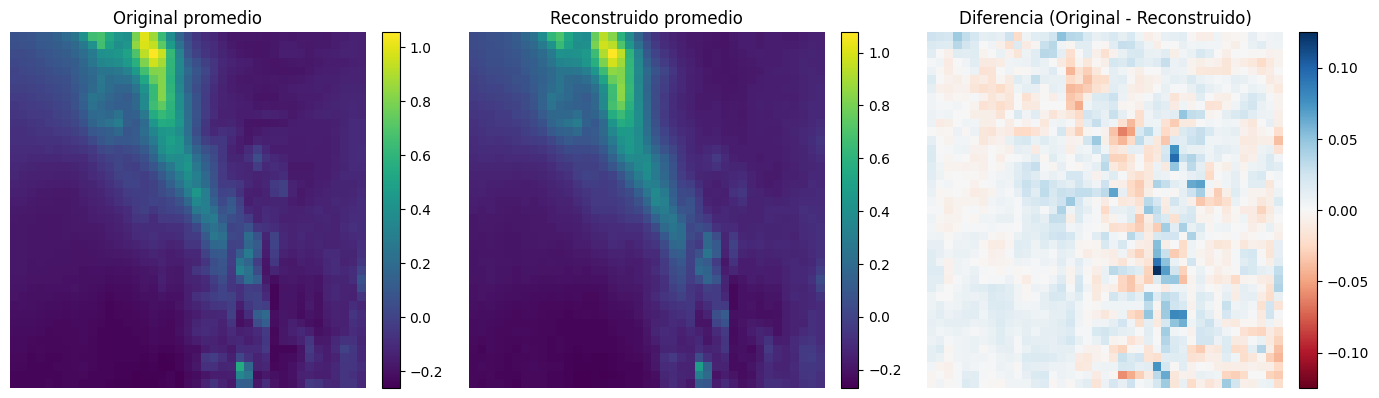

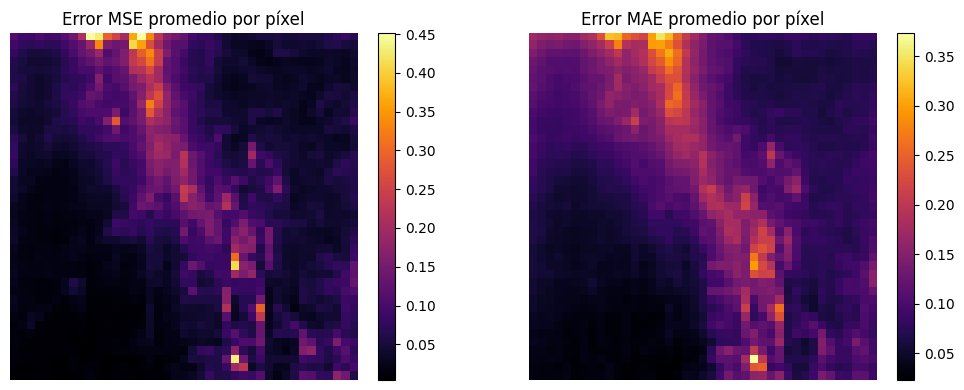

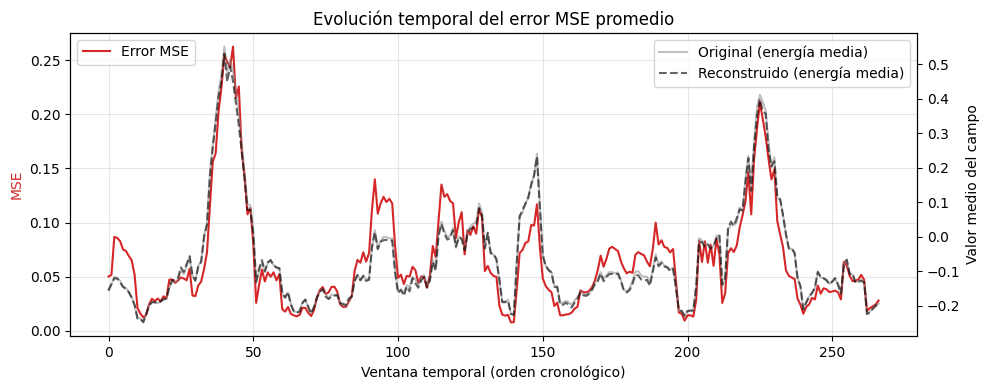

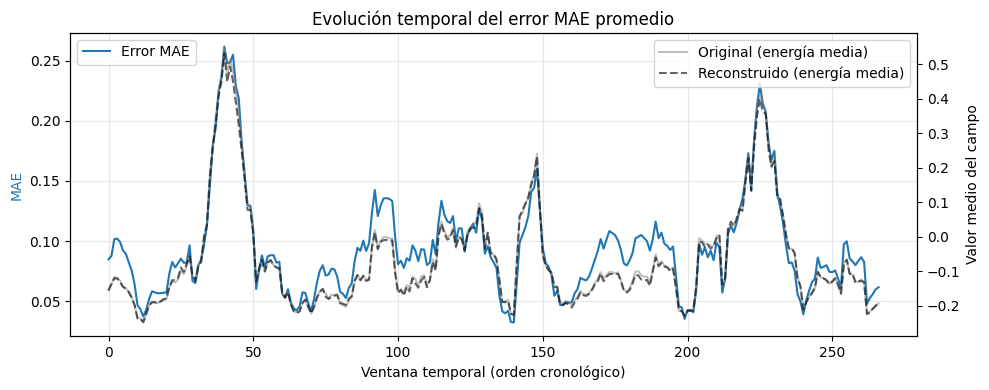

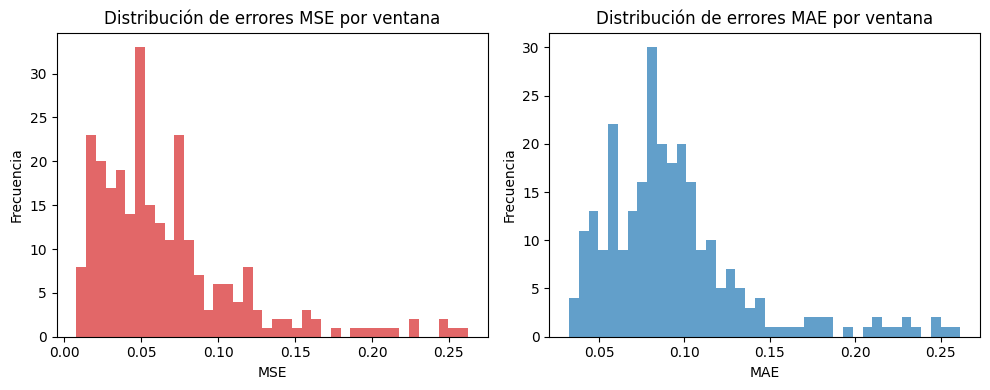

In [26]:
compare_plots_error(recons, Xte_w)

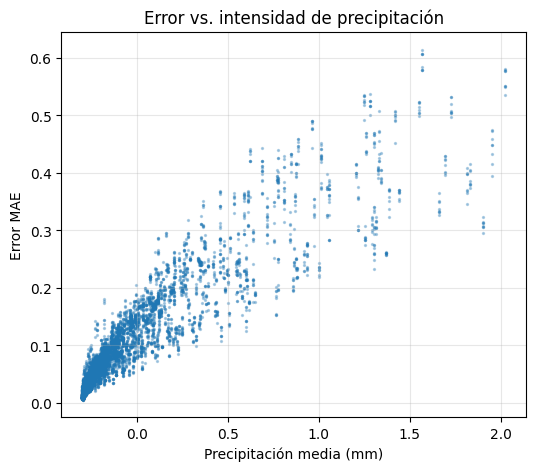

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Valor medio vs error (por frame)
orig_vals = np.mean(Xte_w[..., 0], axis=(2, 3))   # (N, T)
err_vals  = np.mean(np.abs(recons - Xte_w), axis=(2, 3, 4)) # (N, T)

plt.figure(figsize=(6,5))
plt.scatter(orig_vals.flatten(), err_vals.flatten(), s=2, alpha=0.3)
plt.xlabel("Precipitación media (mm)")
plt.ylabel("Error MAE")
plt.title("Error vs. intensidad de precipitación")
plt.grid(alpha=0.3)
plt.show()